PatchCoreを用いて、画用紙の切れ端の分類を行いました。

参照url
 https://github.com/hcw-00/PatchCore_anomaly_detection

In [1]:
%%capture
!git clone https://github.com/shogoromal/PatchCore_Paper.git
chdir = "PatchCore_Paper"

In [2]:
%%capture
!pip install pyheif
!pip install pytorch-lightning
!pip install faiss-gpu

In [3]:
import os
os.chdir(chdir)

画像の読み込みとクラス定義を、

paper_detect.py の gayoshi_danmen class のインスタンス化で行います。

In [4]:
from paper_detect import *

folder = "paper_image/"

#今回のデモでは、ハサミ部分とちぎり部分の両方が入った画像を使います。
chigiri_file_list = []
both_file_list = ["IMG_0244.HEIC"]
hasami_file_list = []
#hasami_file_list = ["IMG_1508.HEIC","IMG_0242.HEIC","IMG_0243.HEIC"]#学習の際に使うが、今回は使わない

#ちぎり、両方、ハサミの順番でリストにする
input_list = [chigiri_file_list,both_file_list,hasami_file_list]

gayoshi_class = gayoshi_danmen(folder, input_list)

heic形式のデータ→ <HeifFile 3024x4032 RGB with 36578304 bytes data>
画像処理ライブラリPILの形式→ <PIL.Image.Image image mode=RGB size=3024x4032 at 0x78F43094CE20>


canny法を利用して、画像の中でコントラストが大きい部分(白と黒の境界)のみを抽出する。

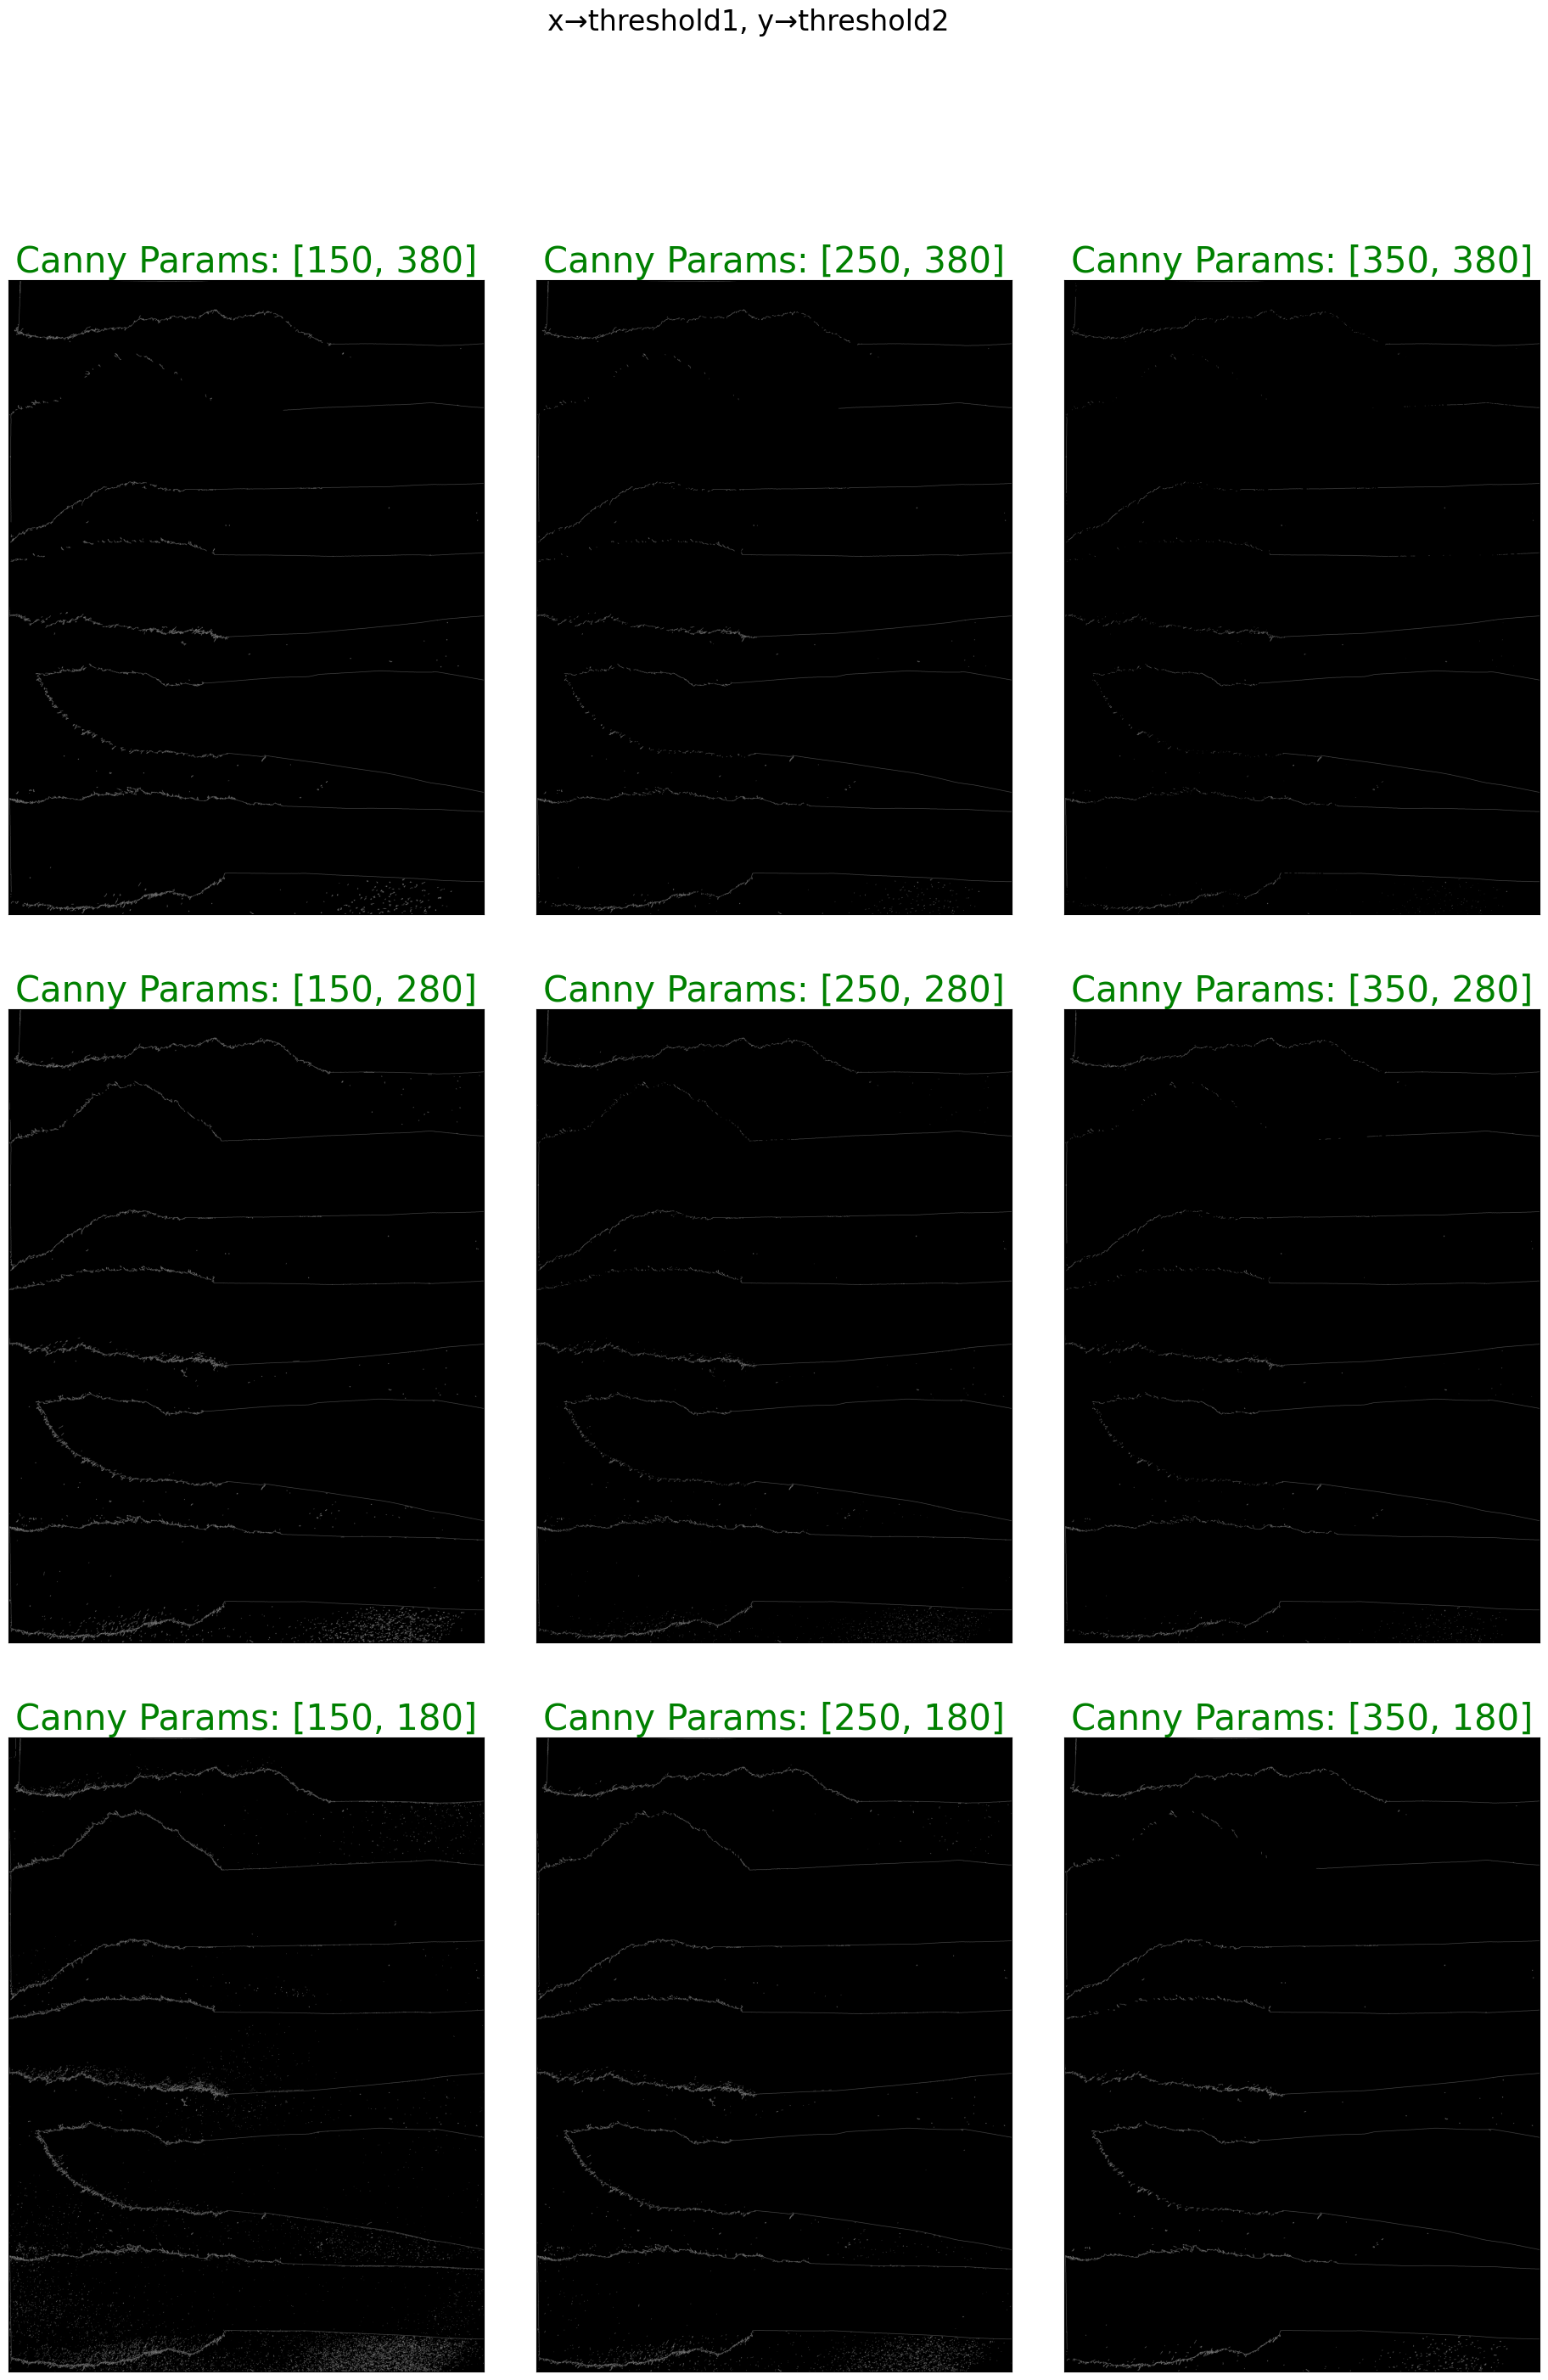

In [5]:
#エッジの画像のチェック canny_edge_check(画像の種類、リストの何番目か、cannyのパラメータ、パラメータを動かす範囲)
#ここで引数として使用したcanny法のパラメータが、実際に画像を分割する際の設定になるため注意。(初期値は、both:(250, 280), hasami:(150, 480))
#hasamiの画像の場合(150,480)くらいがベスト

gayoshi_class.canny_edge_check("both", 0, (250,280), 100)

サイズを引数で指定して、上の画像でエッジ検出した部分のみを抽出

In [6]:
#引数は画像のサイズ
boundary_dict_original, _ = gayoshi_class.search_danmen((250,250))

chigiri の数→ 0
both 1 →完了
both の数→ 147
hasami の数→ 0


切り取った画像の一部をチェックする。

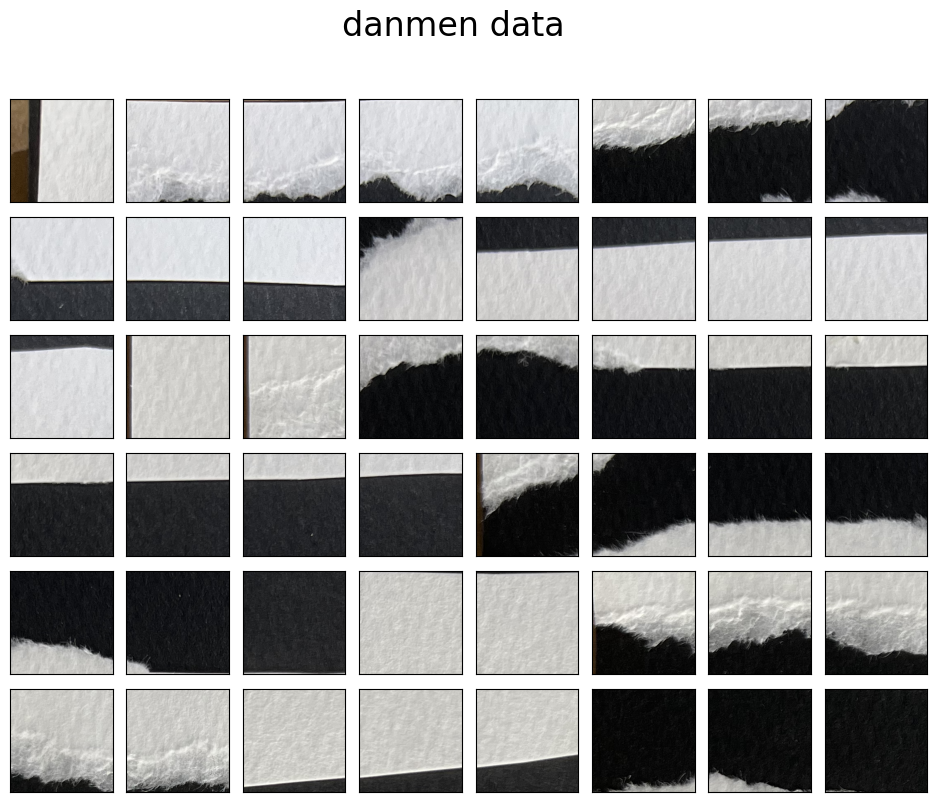

In [7]:
#def show_pics(self, data, row ,col, start_num, title, fig_size):
gayoshi_class.show_pics(boundary_dict_original["both"], 6, 8, 0, "danmen data", (12,9))

上で切り取った画像に対して、PatchCoreを適用する

In [8]:
from callback import MyCallback
from patchcore import PatchCore

In [9]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#引数を丸々普通に記述する、辞書型で渡す
#あとで不要な引数を削除する
hparams = {
  'num_epochs': 1,
  'batch_size': 32,
  'input_size': 250,
  #'coreset_sampling_ratio': 0.001,#固定した
  #'input_size': 250,
  'coreset_sampling_ratio': 0.001,
  'project_root_path': "",  # 学習時のembeddingを保存する場所
  'n_neighbors': 9,
  'gayoshi_train_img_list': boundary_dict_original["hasami"],
  'croped_img_list': boundary_dict_original["both"], #croped_img_list,
  'device': device
}

In [10]:
import pytorch_lightning as pl
from pytorch_lightning import LightningModule as pl_module

phase = 'test'#学習モードとの切り替えを行う

trainer = pl.Trainer(max_epochs = 1,
                     devices = 1,
                     callbacks=[MyCallback()])

model = PatchCore(hparams)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
Downloading: "https://github.com/pytorch/vision/zipball/v0.9.0" to /root/.cache/torch/hub/v0.9.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFA

In [11]:
if phase == 'train':
  trainer.fit(model)
  trainer.test(model)
elif phase == 'test':
  trainer.test(model)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

In [12]:
from utils import cvt2heatmap, min_max_norm, heatmap_on_image
import cv2

def show_result(model, indices):
  # nrowsを2倍にして、各インデックスごとに2行のプロットを用意
  fig, axes = plt.subplots(nrows=2, ncols=len(indices), figsize=(15, 10))

  for col, idx in enumerate(indices):
    input_img = model.input_img[idx]
    annomaly_map = model.test_result_annomaly_map[idx]
    score = model.annomaly_score[idx]

    if annomaly_map.shape != input_img.shape:
      annomaly_map = cv2.resize(annomaly_map, (input_img.shape[1], input_img.shape[0]))

    annomaly_map_norm = min_max_norm(annomaly_map, model.max_Nb)
    annomaly_map_norm_hm = cvt2heatmap(annomaly_map_norm*255)
    hm_on_img = heatmap_on_image(annomaly_map_norm_hm, input_img)

    # ヒートマップが適用された画像を上段に表示
    axes[0, col].imshow(hm_on_img)
    axes[0, col].axis('off')
    axes[0, col].set_title(f'Score: {score:.2f}')

    # 元の入力画像を下段に表示
    # input_imgがBGR形式の場合、RGBに変換する必要があるかもしれません
    if input_img.shape[2] == 3:  # RGBまたはBGRチェック
        input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
    axes[1, col].imshow(input_img/255)
    axes[1, col].axis('off')  # 軸を非表示

  plt.tight_layout()
  plt.show()

In [13]:
# 大きい方から3番目までの値を抽出
largest_indices = sorted(range(len(model.annomaly_score)), key=lambda i: model.annomaly_score[i], reverse=True)[0:3]
# 小さい方から3番目までの値を抽出
smallest_indices = sorted(range(len(model.annomaly_score)), key=lambda i: model.annomaly_score[i])[0:3]

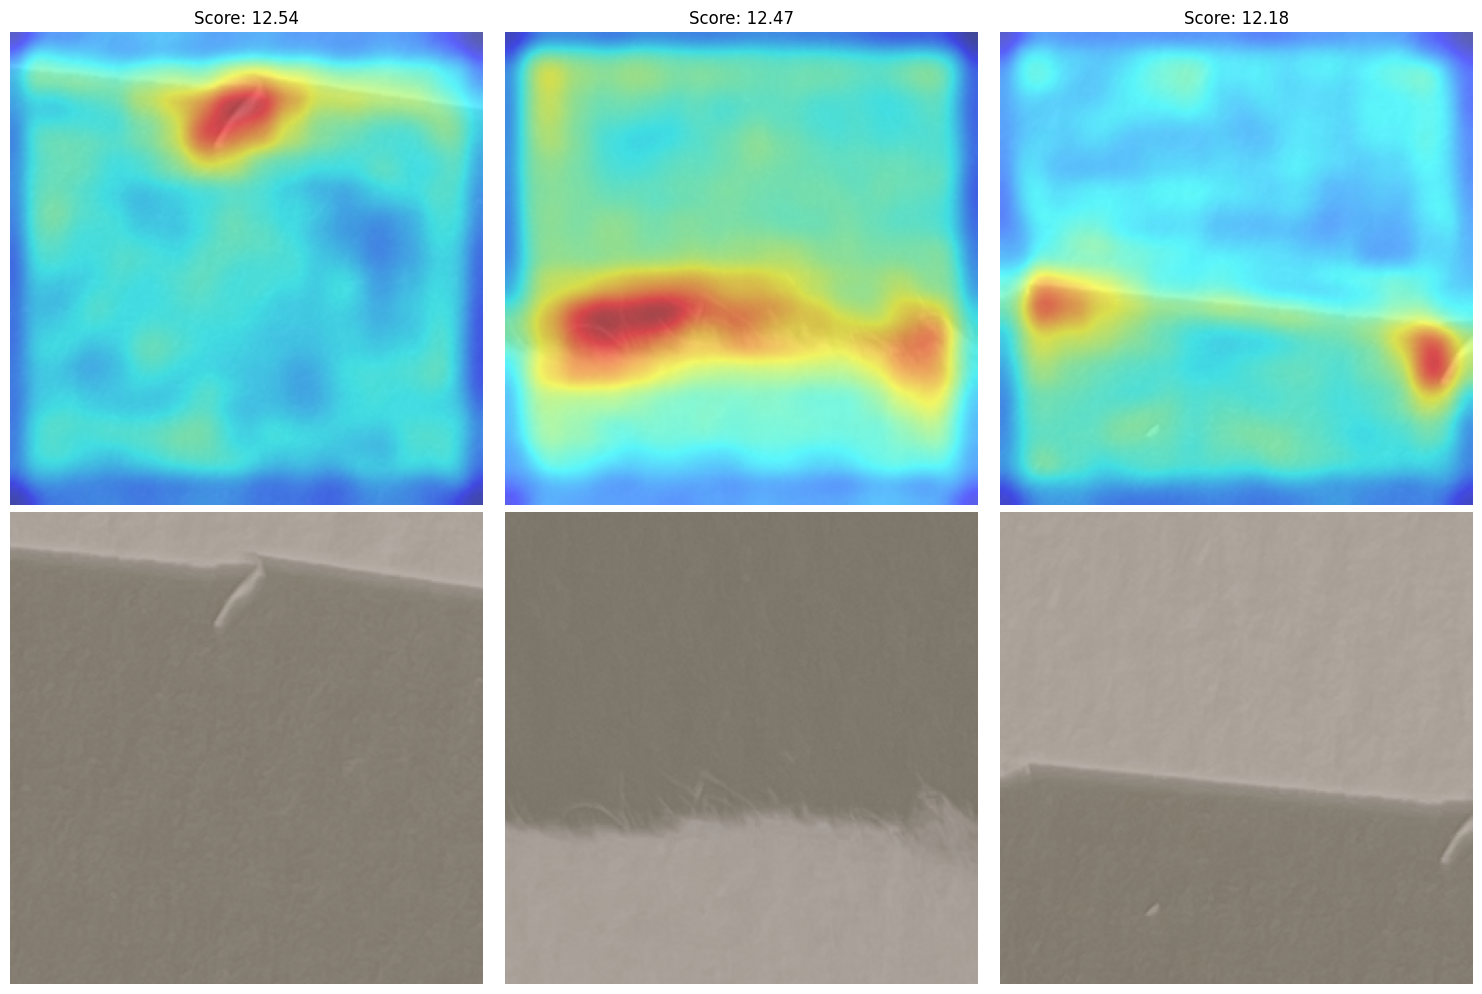

In [14]:
show_result(model, largest_indices)

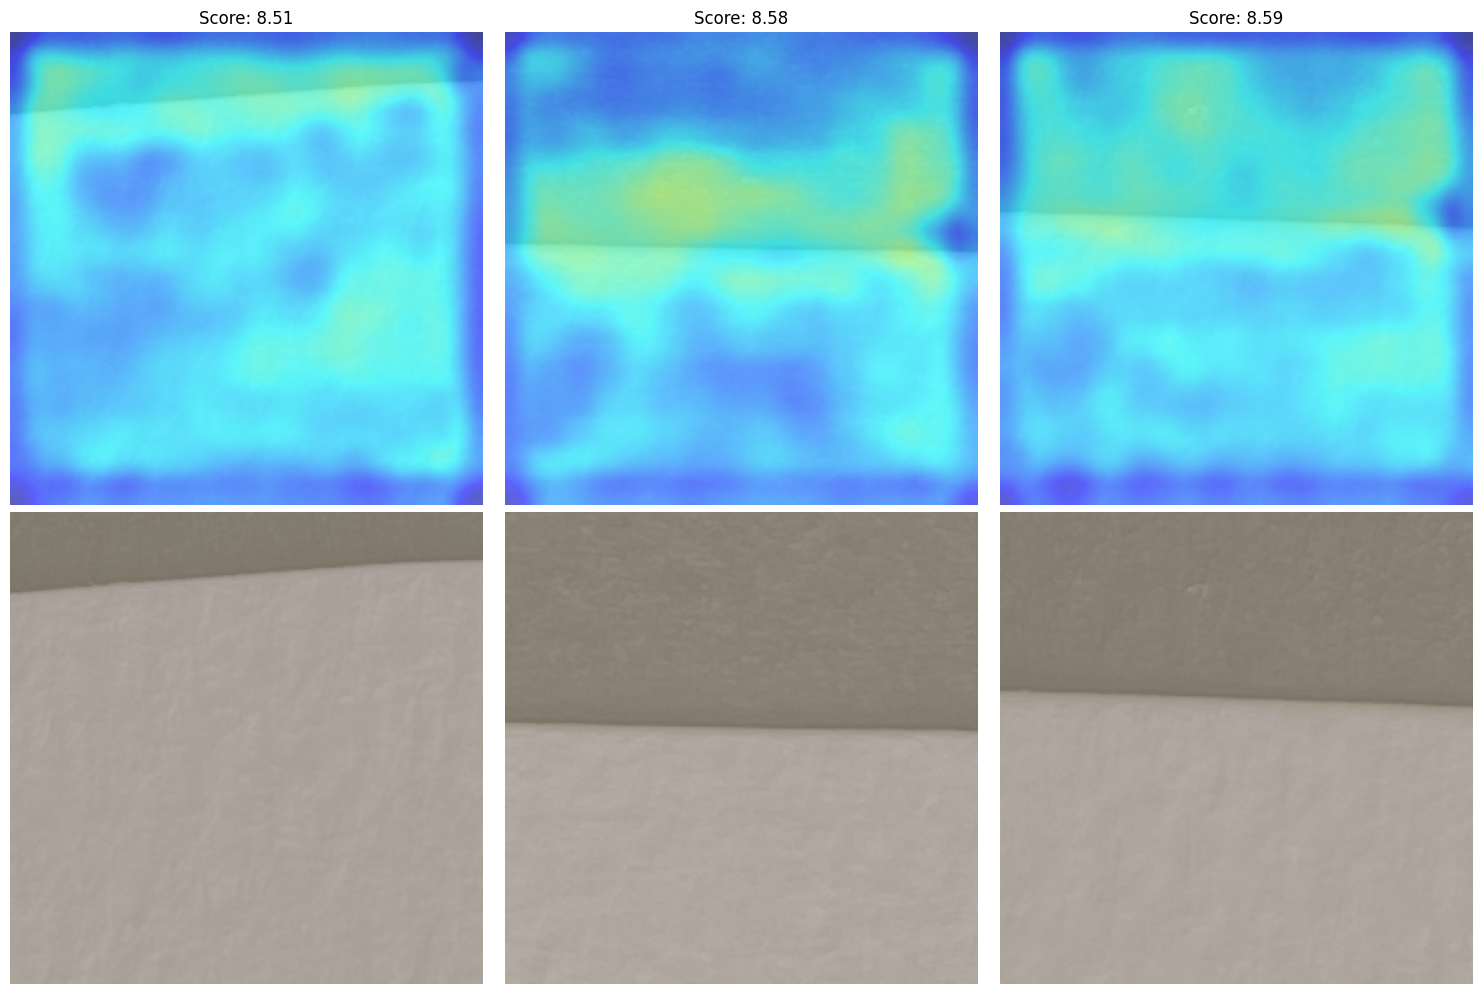

In [15]:
show_result(model, smallest_indices)